In [2]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

db = 'chinook.db'

def run_query(q):
    with sqlite3.connect(db) as conn:
        return pd.read_sql(q, conn)

def run_command(c):
    with sqlite3.connect(db) as conn:
        conn.isolation_level = None
        conn.execute(c)

def show_tables():
    q = '''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table","view");
    '''
    return run_query(q)

show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


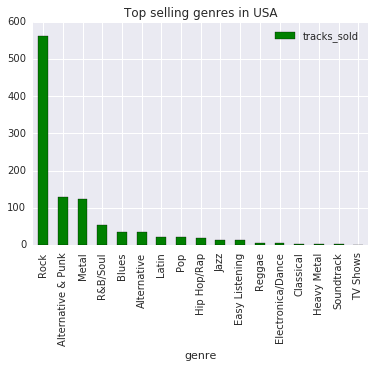

In [3]:
q1=('''
WITH new AS
    (SELECT il.track_id,t.genre_id,g.name FROM invoice_line as il
     INNER JOIN track as t ON il.track_id=t.track_id
     INNER join genre as g ON g.genre_id=t.genre_id
     INNER JOIN invoice as i ON il.invoice_id=i.invoice_id
     INNER JOIN customer as c ON i.customer_id=c.customer_id
     WHERE c.country='USA' 
    )
    
SELECT new.name AS genre,
       COUNT(new.track_id) AS tracks_sold,
       CAST(COUNT(new.track_id) AS Float)/CAST((SELECT COUNT(*) FROM new) AS Float) AS percentage
FROM new
GROUP BY 1 
ORDER BY 2 DESC
    ''')
genre_df=run_query(q1)
genre_df.plot.bar(x='genre',y='tracks_sold',color='green')
plt.title('Top selling genres in USA')




Based on the bar plot on top selling genres in USA, we should purchase the albums from the artists: 'Red Tone(Punk)','Slim Jim Bites(Blues)'and 'Meteor and the Girls(Pop)'.
We should rally on purchasing more albums from Rock genre, as it accounts for more than 50% of the sales.

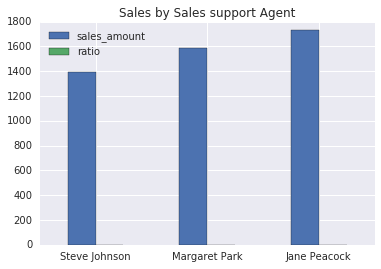

In [5]:
import seaborn as sns
sales_query='''
WITH sales AS
    (SELECT il.total,e.first_name||' '||e.last_name AS sales_rep,e.hire_date
     FROM invoice AS il
     INNER JOIN customer AS c ON c.customer_id=il.customer_id
     INNER JOIN employee AS e ON e.employee_id=c.support_rep_id
    )
SELECT s.sales_rep,
       s.hire_date,
       SUM(s.total) AS sales_amount,
       CAST(SUM(s.total) AS Float)/CAST((SELECT SUM(total) FROM sales) AS Float) AS ratio
FROM sales as s
GROUP BY 1
ORDER BY 2 DESC;
'''
sales_df=run_query(sales_query)
sales_df.set_index("sales_rep", drop=True, inplace=True)
sales_df.plot.bar()
plt.title("Sales by Sales support Agent")
plt.xticks(rotation='horizontal')
plt.xlabel('')


In [5]:
sales_by_country = '''
WITH country_or_other AS
    (
     SELECT
       CASE
           WHEN (
                 SELECT count(*)
                 FROM customer
                 where country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       c.customer_id,
       il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
    ),
updated_by_country AS 
    (SELECT
        country,
        count(distinct customer_id) customers,
        SUM(unit_price) total_sales,
        SUM(unit_price) / count(distinct customer_id) customer_lifetime_value,
        SUM(unit_price) / count(distinct invoice_id) average_order,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM country_or_other
    GROUP BY country
    ORDER BY sort ASC, total_sales DESC)

SELECT country,customers,total_sales,customer_lifetime_value,average_order
FROM updated_by_country;
'''
by_country=run_query(sales_by_country)
by_country

,country,customers,total_sales,customer_lifetime_value,average_order
0,USA,13,1040.49,80.037692,7.942672
1,Canada,8,535.59,66.948750,7.047237
2,Brazil,5,427.68,85.536000,7.011148
3,France,5,389.07,77.814000,7.781400
4,Germany,4,334.62,83.655000,8.161463
5,Czech Republic,2,273.24,136.620000,9.108000
6,United Kingdom,3,245.52,81.840000,8.768571
7,Portugal,2,185.13,92.565000,6.383793
8,India,2,183.15,91.575000,8.721429
9,Other,15,1094.94,72.996000,7.448571


In [73]:
test='''
WITH merged AS(
SELECT il.invoice_id,tr.track_id,tr.album_id
FROM invoice_line AS il
INNER JOIN track as tr ON il.track_id=tr.track_id
)

SELECT * FROM merged
'''
alb='''
SELECT track_id,album_id FROM track
'''
tst=run_query(test)
album=run_query(alb)
count_yes=0
count_no=0
#for id in tst['invoice_id'].unique():
track_list=tst['track_id'][tst['invoice_id']==2].tolist()
album_list=set(tst['album_id'][tst['invoice_id']==2].tolist())
for value in album_list:
    album_songs=album['track_id'][album['album_id']==value].tolist()
    if set(album_songs).issubset(set(track_list)):
        count_yes+=1
    else:
        count_no+=1    
count_no

10